In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<center><h1>Assignment 3 : Language Models <br>( LSTM and Transformer Based Models )

<center><h2>Part 1 : LSTM Text Generation/Prediction Model Implementation

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Importing required modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import os,string

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
import keras.utils as ku
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,Dense,Dropout

2024-07-07 02:00:32.139223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 02:00:32.139376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 02:00:32.263145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
working_directory = '../input/nyt-comments/'

In [6]:
# Picking out all headlines from the articles .csv files.
all_headlines = []
for filename in os.listdir(working_directory):
    if 'Articles' in filename: 
        article_df = pd.read_csv(working_directory + filename)
        all_headlines.extend(list(article_df.headline.values))

# Picking out all comments from the comments .csv files.
all_comments = []
for filename in os.listdir(working_directory):
    if 'Comments' in filename: 
        comments_df = pd.read_csv(working_directory + filename)
        all_comments.extend(list(comments_df.commentBody.values))

In [7]:
print(f"Size of Article Headings Dataframe : {len(all_headlines)}")
print(f"Size of Article Comments Dataframe : {len(all_comments)}")

Size of Article Headings Dataframe : 9335
Size of Article Comments Dataframe : 2176364


<h3>Since the size of comments is comparatively large, We use the headlines dataframe for our further training and testing.

In [8]:
all_headlines[:10] # Last 10 headlines.

['N.F.L. vs. Politics Has Been Battle All Season Long',
 'Voice. Vice. Veracity.',
 'A Stand-Up’s Downward Slide',
 'New York Today: A Groundhog Has Her Day',
 'A Swimmer’s Communion With the Ocean',
 'Trail Activity',
 'Super Bowl',
 'Trump’s Mexican Shakedown',
 'Pence’s Presidential Pet',
 'Fruit of a Poison Tree']

In [9]:
# Function for Data Cleaning and Homogenization.
def clean_corpus(corpus):
    text_string = "".join(letter for letter in corpus if letter not in string.punctuation).lower()
    text_string = text_string.encode("utf8").decode("ascii","ignore")
    return text_string

In [10]:
corpus = [clean_corpus(letter) for letter in all_headlines]

In [11]:
corpus[:10] # We can observe that all the punctuation present in the corpus are removed and all words/letters are converted to lowercase.

['nfl vs politics has been battle all season long',
 'voice vice veracity',
 'a standups downward slide',
 'new york today a groundhog has her day',
 'a swimmers communion with the ocean',
 'trail activity',
 'super bowl',
 'trumps mexican shakedown',
 'pences presidential pet',
 'fruit of a poison tree']

In [12]:
# Creation of N-Grams
tokenizer = Tokenizer()

def get_sequence(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences,total_words

In [13]:
input_sequences ,total_words_in_corp = get_sequence(corpus)

In [14]:
print(f"Input Sequence Example: \n{input_sequences[:8]}\n")
print(f"Total Number of Words in Corpus: {total_words_in_corp}")

Input Sequence Example: 
[[916, 149], [916, 149, 213], [916, 149, 213, 74], [916, 149, 213, 74, 476], [916, 149, 213, 74, 476, 203], [916, 149, 213, 74, 476, 203, 69], [916, 149, 213, 74, 476, 203, 69, 29], [916, 149, 213, 74, 476, 203, 69, 29, 183]]

Total Number of Words in Corpus: 11265


In [15]:
print(len(input_sequences))
print(total_words_in_corp)

51770
11265


In [16]:
def generate_padded_seq(input_sequences):
    max_seq_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,maxlen = max_seq_len,padding = 'pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label,num_classes = total_words_in_corp)
    return predictors, label, max_seq_len

In [17]:
predictors, label, max_sequence_len = generate_padded_seq(input_sequences)

In [18]:
predictors

array([[    0,     0,     0, ...,     0,     0,   916],
       [    0,     0,     0, ...,     0,   916,   149],
       [    0,     0,     0, ...,   916,   149,   213],
       ...,
       [    0,     0,     0, ...,   243,    10, 11264],
       [    0,     0,     0, ...,    10, 11264,    81],
       [    0,     0,     0, ..., 11264,    81,     2]], dtype=int32)

In [19]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
print(predictors.size)
print(label.size)

1190710
583189050


<h2>LSTM Implementation

In [21]:
def create_model(max_sequence_len,total_words):
    input_len = max_sequence_len -1
    model = Sequential()
    
    # Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length = input_len))
    
    # Add Hidden Layer - 1: LSTM
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words,activation = "softmax"))
    
    model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
    
    return model

In [22]:
LSTM_model = create_model(max_sequence_len,total_words_in_corp)
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = LSTM_model.fit(predictors, label, epochs = 50, verbose = 1,validation_split = 0.2)

Epoch 1/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.0330 - loss: 8.0407 - val_accuracy: 0.0350 - val_loss: 7.8586
Epoch 2/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0453 - loss: 7.3827 - val_accuracy: 0.0398 - val_loss: 7.9394
Epoch 3/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0536 - loss: 7.2308 - val_accuracy: 0.0523 - val_loss: 8.0353
Epoch 4/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0628 - loss: 6.9951 - val_accuracy: 0.0536 - val_loss: 8.0707
Epoch 5/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0700 - loss: 6.8254 - val_accuracy: 0.0532 - val_loss: 8.1906
Epoch 6/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0731 - loss: 6.5984 - val_accuracy: 0.0608 - val_loss: 8.3059
Epoch 7/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0800 - loss: 6.3852 - val_accuracy: 0.0625 - val_loss: 8.4628
Epoch 8/50
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.0851 -

In [24]:
history2 = LSTM_model.fit(predictors,label,epochs = 10, verbose = 1,validation_split = 0.2)

Epoch 1/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5561 - loss: 2.1618 - val_accuracy: 0.0712 - val_loss: 12.4977
Epoch 2/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5568 - loss: 2.1370 - val_accuracy: 0.0699 - val_loss: 12.5502
Epoch 3/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5649 - loss: 2.1106 - val_accuracy: 0.0695 - val_loss: 12.6008
Epoch 4/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5696 - loss: 2.0764 - val_accuracy: 0.0704 - val_loss: 12.6638
Epoch 5/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5781 - loss: 2.0406 - val_accuracy: 0.0716 - val_loss: 12.7248
Epoch 6/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5727 - loss: 2.0438 - val_accuracy: 0.0701 - val_loss: 12.7753
Epoch 7/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.5815 - loss: 2.0094 - val_accuracy: 0.0720 - val_loss: 12.8448
Epoch 8/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0

<h2>Generating Text

In [25]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],maxlen = max_sequence_len - 1,padding = "pre")
        predicted = model.predict(token_list,verbose = 0)
        predicted = np.argmax(predicted, axis=-1)

        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text.title()

In [26]:
print(generate_text("language",5,LSTM_model,max_sequence_len))
print(generate_text("model",5,LSTM_model,max_sequence_len))
print(generate_text("using",5,LSTM_model,max_sequence_len))
print(generate_text("python",5,LSTM_model,max_sequence_len))

Language Lessons At The New Bar
Model Of A Lynching And A
Using A Myth To Hold In
Python A Compliment Of Takeout Teeter


<center><h2>Part 2 : Transformer Text Generation/Prediction Model Implementation

In [27]:
# Importing the modules

import numpy as np
import re
import pandas as pd
import tensorflow as tf
import torch

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout, Bidirectional, Flatten, Layer, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

<h4>Since we are comparing the accuracy and other metrics, we require to use the same corpus. Hence we will be reusing the corpus that we created in LSTM for our Transformer based implementation as well.

In [28]:
# Displaying the type and sample of our corpus
print(type(corpus))
corpus[:10]

<class 'list'>


['nfl vs politics has been battle all season long',
 'voice vice veracity',
 'a standups downward slide',
 'new york today a groundhog has her day',
 'a swimmers communion with the ocean',
 'trail activity',
 'super bowl',
 'trumps mexican shakedown',
 'pences presidential pet',
 'fruit of a poison tree']

In [29]:
# Displaying our input sequence which was created from the corpus during LSTM model generation. 
display(input_sequences[0:5])

[[916, 149],
 [916, 149, 213],
 [916, 149, 213, 74],
 [916, 149, 213, 74, 476],
 [916, 149, 213, 74, 476, 203]]

In [33]:
max_length_of_input_seq = max([len(x) for x in input_sequences])
print(max_len)

24


In [34]:
padded_input_seq = pad_sequences(input_sequences, maxlen = max_length_of_input_seq, padding='pre')

In [35]:
vocab_size = len(tokenizer.word_index) + 1

In [37]:
# Creating the predictors and their accompanied labels from the padded input sequence.
predictors = padded_input_seq[:,:-1]
label = padded_input_seq[:,-1]

# Encoding the labels into catagorical, similar to the LSTM implementation.
label = to_categorical(label)

# Displaying the sample of predictors and labels.
print(type(predictors))
display(predictors)
print(type(label))
display(label)

<class 'numpy.ndarray'>


array([[    0,     0,     0, ...,     0,     0,   916],
       [    0,     0,     0, ...,     0,   916,   149],
       [    0,     0,     0, ...,   916,   149,   213],
       ...,
       [    0,     0,     0, ...,   243,    10, 11264],
       [    0,     0,     0, ...,    10, 11264,    81],
       [    0,     0,     0, ..., 11264,    81,     2]], dtype=int32)

<class 'numpy.ndarray'>


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# Model pass and layers creation function. 

class Transformer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [42]:
# Input and output Layers setting.

inputs = Input(shape = (max_len-1,))
embedding_layer = Embedding(vocab_size,200)(inputs)
transformer_block = Transformer(embed_dim=200,num_heads=4,ff_dim=128)
x = transformer_block(embedding_layer,training=True)
x = LayerNormalization(epsilon=1e-6)(x)
x = Dropout(0.2)(x)
x = Dense(512)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

outputs = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs = inputs, outputs = outputs)

In [43]:
# Model compilation and Summary generation. 

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 23, 200)        │     2,253,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer (Transformer)       │ (None, 23, 200)        │       694,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 23, 200)        │           400 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 23, 512)        │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 23, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 11265)          │   132,667,905 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,719,145 (517.73 MB)

 Trainable params: 135,719,145 (517.73 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Callback functions definition and their parameters declaration.

rlrong = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    mode = 'min',
    min_lr = 1e-5,
    patience = 2,
    verbose = 1
)
estop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 30,
    verbose = 1,
    restore_best_weights = True
)

In [47]:
# Model training and fitting.

history_transformers = model.fit(predictors, label, epochs = 10, verbose = 1, validation_split=0.2, callbacks = [rlrong,estop])

Epoch 1/10
   7/1295 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.0120 - loss: 10.3895     

I0000 00:00:1720319028.946771     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720319028.966814     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0135 - loss: 9.1272

W0000 00:00:1720319067.727910     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720319069.860415     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.0135 - loss: 9.1268 - val_accuracy: 0.0641 - val_loss: 7.7498 - learning_rate: 0.0010
Epoch 2/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.1188 - loss: 6.6242 - val_accuracy: 0.0996 - val_loss: 7.6685 - learning_rate: 0.0010
Epoch 3/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5069 - loss: 2.7918 - val_accuracy: 0.0879 - val_loss: 9.7232 - learning_rate: 0.0010
Epoch 4/10
1294/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7003 - loss: 1.5780
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7002 - loss: 1.5783 - val_accuracy: 0.0807 - val_loss: 10.6617 - learning_rate: 0.0010
Epoch 5/10
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.7881 - loss: 1.0354 - val_accuracy: 0.0851 - val_loss: 11.0263 - learning_rate: 2.0000e-04
Epoch 6/10
1294/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8

In [50]:
# Generating and predicting using the transformer Model.

print(generate_text("language",5,model,max_length_of_input_seq))
print(generate_text("model",5,model,max_length_of_input_seq))
print(generate_text("using",5,model,max_length_of_input_seq))
print(generate_text("python",5,model,max_length_of_input_seq))

Language A Nation To Be A
Model In The First Are In
Using A New York Today A
Python In The World Of The


<center><h2>Comparision of Model Performance

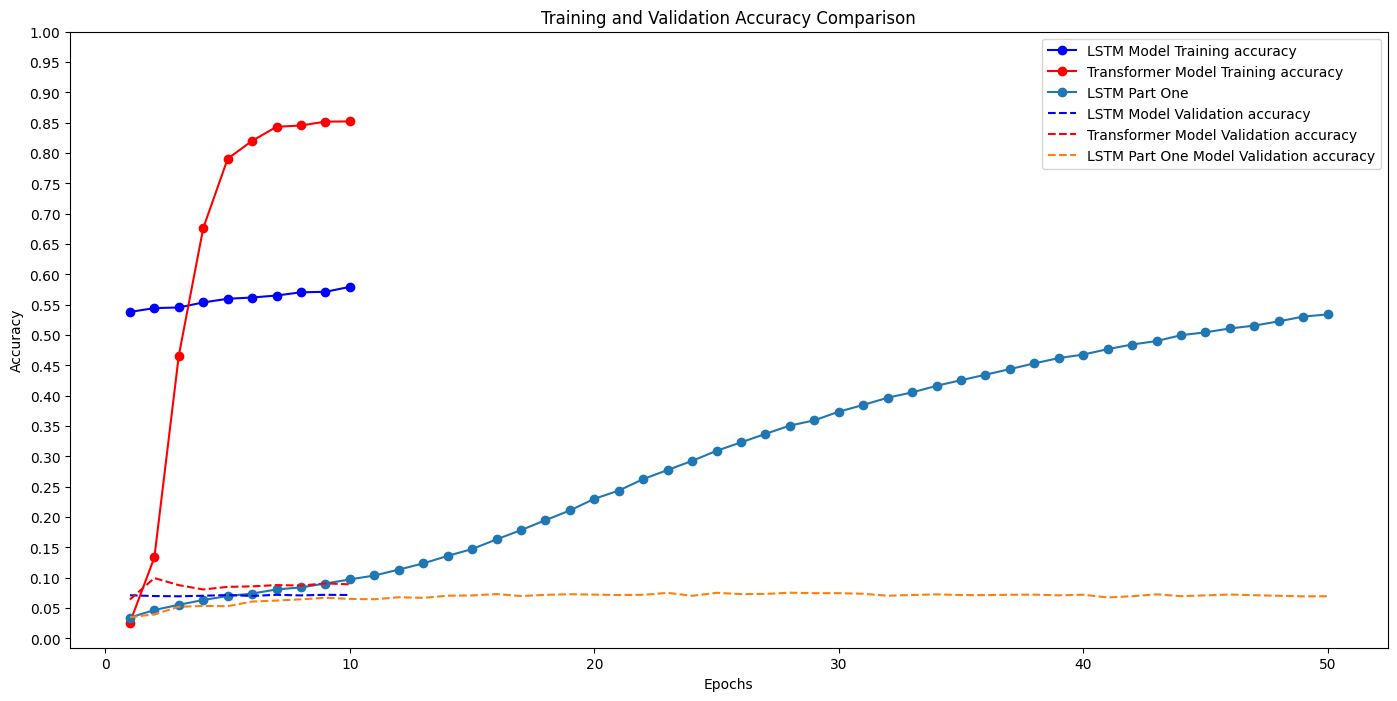

In [71]:
# Extract accuracy and epoch values for both models

accuracy1 = history2.history['accuracy']
val_accuracy1 = history2.history.get('val_accuracy')

accuracy_temp = history.history['accuracy']
val_accuracy_temp = history.history.get('val_accuracy')


accuracy2 = history_transformers.history['accuracy']
val_accuracy2 = history_transformers.history.get('val_accuracy')

epochs1 = range(1, len(accuracy1) + 1)
epochs_temp = range(1,len(accuracy_temp) + 1)
epochs2 = range(1, len(accuracy2) + 1)

# Set the figure size
plt.figure(figsize=(17, 8))

# Plot training accuracy for both models

plt.plot(epochs1, accuracy1, 'bo-', label = 'LSTM Model Training accuracy')
plt.plot(epochs2, accuracy2, 'ro-', label = 'Transformer Model Training accuracy')
plt.plot(epochs_temp, accuracy_temp, 'o-', label = 'LSTM Part One')

# If validation accuracy exists for both models, plot it as well
if val_accuracy1 and val_accuracy2:
    plt.plot(epochs1, val_accuracy1, 'b--', label='LSTM Model Validation accuracy')
    plt.plot(epochs2, val_accuracy2, 'r--', label='Transformer Model Validation accuracy')
    plt.plot(epochs_temp, val_accuracy_temp,'--', label='LSTM Part One Model Validation accuracy')

# Adding title and labels
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Customize y-axis for more granularity
y_ticks = np.arange(0, 1.05, 0.05)  # Adjust the start, stop, and step as needed
plt.yticks(y_ticks)

# Display the plot
plt.show()

<h3>References</h3>
    <li><a>https://keras.io/api/keras_nlp/tokenizers/tokenizer/
    <li><a>https://www.youtube.com/watch?v=Nv-Pa3XiqRU
    <li><a>https://www.kaggle.com/code/madhurakansara/text-generation-lstms
    <li><a>https://huggingface.co/docs/transformers/en/model_doc/bertv
    <li><a>https://www.kaggle.com/code/tushargandhi77/next-word-prediction-using-transformers